# Script for Measurements
2 phase shifters interferometer

In [1]:
import pocketvna
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from stlab.devices.Vaunix_Phase import Vaunix_Phase
import time

Could not load "PocketVnaApi_x64" by systempath. Trying another one "C:\Users\Jacco\Documents\GitHub\bep-jacco-van-leenen\Code\PocketVnaApi_x64.dll"


## Setting up the VNA

In [2]:
# Connecting the VNA
driver = pocketvna.Driver()

print('Driver is created: {} devices connected..'.format(driver.count()))
for i in range(0, driver.count()):
    print('Device {}'.format(i))
    print('\t {}'.format(driver.info_at(i)))

if not driver.connect_to(0):
    print('Failed to connect')

Driver is created: 0 devices connected..
Failed to connect


## Setting up the Phase Shifters

In [3]:
# Connecting the phase shifters
ph1 = Vaunix_Phase(23869)
ph2 = Vaunix_phase(19164)

# Setting the frquency to the minimum
ph1.SetFrequency(4000000000)
ph2.SetFrequency(4000000000)

# Setting the phase to the minimum
ph1.SetPhase(0)
ph2.SetPhase(0)

# Checking if the phases and the frequencies are set correctly
print("Phase of Phase Shifter 1: {}\nFrequency of Phase Shifter 1: {}".format(ph1.GetPhase(), ph1.GetFrequency()))
print("Phase of Phase Shifter 2: {}\nFrequency of Phase Shifter 2: {}".format(ph2.GetPhase(), ph2.GetFrequency()))


ValueError: No devices found!

## Basic Variables

In [4]:
# Some of the basic variables the program needs

# Setting the figure size of the plots
plt.rcParams['figure.figsize'] = (10,6)


## Measuring

In [ ]:
def data_chopping(s21, deg, name):
    
    for i in range(6):
        # 1GHz range, 1000 steps
        temp_1 = s21[i*1000:(i+1)*1000]
        file_name ="{}_{}-{}GHz_1000_steps_phase_shift_{}_degrees.dat".format(name, i, i+1, deg)
        save_name = os.path.join("Measurements", file_name)
        data = np.column_stack((temp_1.real, temp_1.imag))
        np.savetxt(save_name, data)
        print("Saved: " + save_name)
        
        # 500 steps 
        temp_2 = np.array([], dtype=np.complex)
        for j in range(0, len(temp_1), 2):
            temp_2 = np.append(temp_2, temp_1[j])
        file_name ="{}_{}-{}GHz_500_steps_phase_shift_{}_degrees.dat".format(name, i, i+1, deg)
        save_name = os.path.join("Measurements", file_name)
        data = np.column_stack((temp_2.real, temp_2.imag))
        np.savetxt(save_name, data)
        print("Saved: " + save_name)
        
        # 250 steps
        temp_2 = np.array([], dtype=np.complex)
        for j in range(0, len(temp_1), 4):
            temp_2 = np.append(temp_2, temp_1[j])
        file_name ="{}_{}-{}GHz_250_steps_phase_shift_{}_degrees.dat".format(name, i, i+1, deg)
        save_name = os.path.join("Measurements", file_name)
        data = np.column_stack((temp_2.real, temp_2.imag))
        np.savetxt(save_name, data)
        print("Saved: " + save_name)
        
        # 100 steps
        temp_2 = np.array([], dtype=np.complex)
        for j in range(0, len(temp_1), 10):
            temp_2 = np.append(temp_2, temp_1[j])
        file_name ="{}_{}-{}GHz_100_steps_phase_shift_{}_degrees.dat".format(name, i, i+1, deg)
        save_name = os.path.join("Measurements", file_name)
        data = np.column_stack((temp_2.real, temp_2.imag))
        np.savetxt(save_name, data)
        print("Saved: " + save_name)

#  ---------------Measurement Variables---------------
# 6000 steps
steps = 6_000
# Start at 1_000_000 
start = 1000000
# End at 6_000_000_000
end = 6000000000
# Average amount of measurements per point
average = 10

# name to be given to the data
name = "michelson_interferometer_1_phase_shifter"

# Phase shifts to measure
phase_shift_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
phase_shift_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Frequency array
freq = np.linspace(start, end, steps, dtype=np.uint64)

# Empty S21 array
s21 = np.zeros(steps, dtype=np.complex)


#  ---------------Measuring---------------
for deg_1 in phase_shift_1:
    
    # Setting the Phase of the phase shifter
    ph1.SetPhase(deg_1)
    
    # For the response time of the phase shifter
    time.sleep(0.1)
    
    for deg_2 in phase_shift_2:
        print("\tAcquiring data for phase shift of {} degrees and {} degrees".format(deg_1, deg_2))
        
        # Setting the phase of the phase shifter
        ph2.SetPhase(deg_2)
        
        # For the response time of the phase shifter
        time.sleep(0.1)
        
        # The Measurement
        s11, s21, s12, s22 = driver.scan(freq, average, pocketvna.NetworkParams.S21)

        # Data Chopping
        data_chopping(s21, deg, name)

## Plotting

1725
1775


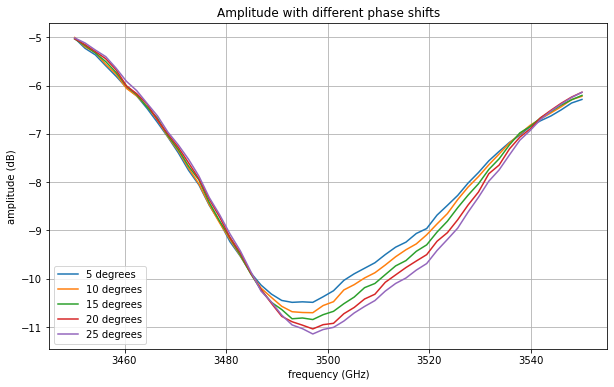

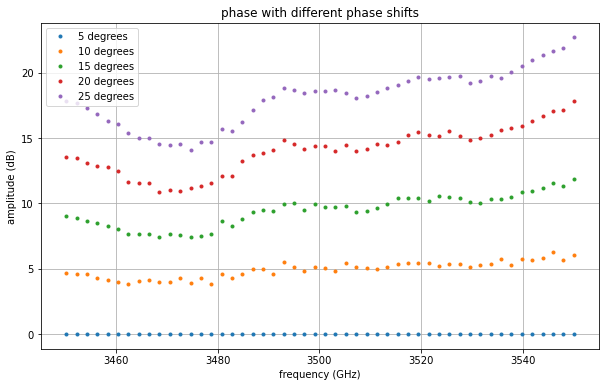

In [15]:
# Plotting the measurements

def opening_files(name, start, end, steps, phase_shift):
    s21 = np.zeros((int((end-start)/(1000/steps)), len(phase_shift)), dtype=np.complex)
    st = int(start//(1000/steps))
    en = int(end//(1000/steps))
    print(st)
    print(en)
    for deg in phase_shift:
        file_name = "{}_{}-{}GHz_{}_steps_phase_shift_{}_degrees.dat".format(name, 0, 6, steps, deg)
        save_name = os.path.join("Measurements", file_name)
        s21_open = np.loadtxt(save_name)
        s21[:, phase_shift.index(deg)] = s21_open[st:en, 0] + s21_open[st:en, 1] * 1j
    cal_s21 = calibrating_measurement(s21, st, en, steps)
    return cal_s21
    
def calibrating_measurement(s21, start, end, steps):
    file_name = "trans_open_{}-{}GHz_{}_steps.dat".format(0, 6, steps)
    save_name = os.path.join("Calibration", file_name)
    trans_open = np.loadtxt(save_name)
    t_open = trans_open[start:end, 0] + trans_open[start:end, 1] * 1j

    file_name = "trans_through_{}-{}GHz_{}_steps.dat".format(0, 6, steps)
    save_name = os.path.join("Calibration", file_name)
    trans_through = np.loadtxt(save_name)
    t_through = trans_through[start:end, 0] + trans_through[start:end, 1] * 1j

    cal_s21 = np.zeros(np.shape(s21), dtype=np.complex128)
    x, y = np.shape(s21)
    for i in range(y):
        cal_s21[:, i] = (s21[:, i] - t_open) / (t_through - t_open)
    return cal_s21

def get_labels(phase_shift):
    labels = []
    for deg in phase_shift:
        labels.append("{} degrees".format(deg))
    return labels

def plot_amplitude(s21, start, end, steps, labels):
    freq = np.linspace(start + (end - start)/steps, end, int((end-start)/(1000/steps)))
    f = np.zeros(np.shape(s21))
    f = f + freq[:, None]
    amp_s21 = np.sqrt(s21.real**2 + s21.imag**2)
    amp_s21 = 20*np.log10(amp_s21)
    plt.figure(20)
    plt.plot(f, amp_s21, "-")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("amplitude (dB)")
    plt.legend(labels)
    plt.grid()
    plt.title("Amplitude with different phase shifts")
    
def plot_phase(s21, start, end, steps, labels):
    freq = np.linspace(start + (end - start)/steps, end, int((end-start)/(1000/steps)))
    f = np.zeros(np.shape(s21))
    f = f + freq[:, None]
    phase = np.arctan2(s21.imag, s21.real)
    phase -= phase[:, 0, None]
    phase = phase * 180/np.pi
    phase[phase< -180] += 360
    phase[phase > 180] -= 360
    plt.figure(10)
    plt.plot(f, phase, ".")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("amplitude (dB)")
    plt.legend(labels)
    plt.grid()
    plt.title("phase with different phase shifts")
    
# Opening the measurement data file
name = "through_with_phase_shifter"
# name = "michelson_interferometer_1_phase_shifter"

# Start and end in MHz
start = 3450
end = 3550
steps = 500
phase_shift = [5, 10, 15, 20, 25]

# ---------------Opening Measurement Files---------------
s21 = opening_files(name, start, end, steps, phase_shift)

# ---------------Calibrating Measurement Files---------------
#s21 = calibrating_measurement(s21, start, end, steps)

# ---------------Plotting Amplitude---------------
# Making labels
labels = get_labels(phase_shift)

plot_amplitude(s21, start, end, steps, labels)

# ---------------Plotting Phase-----------------
plot_phase(s21, start, end, steps, labels)